In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Embedding, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Merge features into train, val and test dataset

In [82]:
def replace_and_merge_features(df: pd.DataFrame, user_features: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces existing user-related columns in a DataFrame with new features from
    the `user_features` DataFrame by merging on 'user_id'.

    The function first identifies common columns (excluding 'user_id') between the
    two DataFrames, drops them from the input DataFrame `df`, and then performs
    a left merge to add the new `user_features`.

    Args:
        df (pd.DataFrame): The target DataFrame to be updated. It must contain a
                          'user_id' column.
        user_features (pd.DataFrame): The source DataFrame containing the new
                                      features and a 'user_id' column for merging.

    Returns:
        pd.DataFrame: A new DataFrame with the old user-related columns replaced
                      by the features from `user_features`.
    """
    # Check if 'user_id' exists in both DataFrames
    if 'user_id' not in df.columns or 'user_id' not in user_features.columns:
        raise ValueError("Both DataFrames must contain a 'user_id' column.")

    # Identify the columns to replace. This includes all common columns
    # except for the 'user_id' column which is used for merging.
    columns_to_replace: List[str] = [
        col for col in user_features.columns
        if col in df.columns and col != 'user_id'
    ]

    print(f"Columns to be replaced: {columns_to_replace}")

    # Drop the old columns from the original DataFrame.
    # We use .copy() to avoid modifying the original DataFrame passed into the function.
    df_new = df.drop(columns=columns_to_replace).copy()

    # Merge the user_features DataFrame into the new DataFrame.
    # The 'left' merge keeps all rows from the original `df_new` and
    # adds the new feature columns based on matching 'user_id's.
    df_merged = pd.merge(df_new, user_features, on='user_id', how='left')

    return df_merged

In [83]:
user_features = pd.read_csv('final_data/user_features.csv')
train_data = pd.read_csv('final_data/train_dataset.csv')
val_data = pd.read_csv('final_data/val_dataset.csv')
# test_data = pd.read_csv('final_data/test_dataset.csv')

# Call the function for each dataset
train_df = replace_and_merge_features(train_data, user_features)
val_df = replace_and_merge_features(val_data, user_features)
# test_df = replace_and_merge_features(test_data, user_features)

# Export to CSV
# train_df.to_csv('final_data/new_train_dataset.csv', index=False)
# val_df.to_csv('final_data/new_val_dataset.csv', index=False)
# test_df.to_csv('final_data/new_test_dataset.csv', index=False)

Columns to be replaced: ['review_similarity', 'category_similarity', 'avg_review_rating_by_user', 'std_review_rating_by_user', 'posts_per_year', 'count_significantly_different_ratings']
Columns to be replaced: ['review_similarity', 'category_similarity', 'avg_review_rating_by_user', 'std_review_rating_by_user', 'posts_per_year', 'count_significantly_different_ratings']


# 1. DATA LOADING

In [84]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
# df = create_sample_data(10000)  # Replace this with: df = pd.read_csv('your_data.csv')
numerical_features = [
    'rating',
    'avg_rating',
    'num_of_reviews',
    'repetitiveness_score',
    'sentiment_score',
    'review_length_words',
    'name_validity',
    'review_similarity',
    'category_similarity',
    'avg_review_rating_by_user',
    'std_review_rating_by_user',
    'posts_per_year',
    'count_significantly_different_ratings'
]

# Text and embedding features
text_column = 'review'
target_column = 'label'
review_embedding_column = 'review_embedding'
business_desc_embedding_column = 'business_desc_embedding'

print(f"\nTraining {target_column} distribution:")
print(train_df[target_column].value_counts())
print(f"\nValidation {target_column} distribution:")
print(val_df[target_column].value_counts())

# Check for missing values
print("\nMissing values in training data:")
print(train_df[numerical_features + [text_column, target_column]].isnull().sum())

# # Handle missing values if any
# train_df = train_df.dropna(subset=numerical_features + [text_column, target_column])
# val_df = val_df.dropna(subset=numerical_features + [text_column, target_column])


Training set shape: (13569, 29)
Validation set shape: (1989, 29)

Training label distribution:
label
relevant      6562
irrelevant    1882
ads           1750
rant          1740
spam          1635
Name: count, dtype: int64

Validation label distribution:
label
relevant      1104
irrelevant     273
rant           255
ads            251
spam           106
Name: count, dtype: int64

Missing values in training data:
rating                                   0
avg_rating                               0
num_of_reviews                           0
repetitiveness_score                     0
sentiment_score                          0
review_length_words                      0
name_validity                            0
review_similarity                        1
category_similarity                      1
avg_review_rating_by_user                1
std_review_rating_by_user                1
posts_per_year                           1
count_significantly_different_ratings    1
review                    

# 2. EMBEDDING PARSING

In [85]:
# Function to parse embedding strings to numpy arrays
def parse_embedding(embedding_str):
    """Parse embedding string to numpy array"""
    if pd.isna(embedding_str):
        return np.zeros(384)  # Default embedding size, adjust if needed

    # Remove brackets and split by whitespace/newlines
    clean_str = embedding_str.strip('[]').replace('\n', ' ')
    # Split and convert to float
    values = [float(x) for x in clean_str.split() if x.strip()]
    return np.array(values)

# Parse embeddings for training data
print("Parsing training embeddings...")
train_df['review_embedding_parsed'] = train_df[review_embedding_column].apply(parse_embedding)
train_df['business_desc_embedding_parsed'] = train_df[business_desc_embedding_column].apply(parse_embedding)

# Parse embeddings for validation data
print("Parsing validation embeddings...")
val_df['review_embedding_parsed'] = val_df[review_embedding_column].apply(parse_embedding)
val_df['business_desc_embedding_parsed'] = val_df[business_desc_embedding_column].apply(parse_embedding)

Parsing training embeddings...
Parsing validation embeddings...


# 3. TEXT PREPROCESSING

In [86]:
# Text preprocessing parameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100      # Maximum review length

# Initialize and fit tokenizer on training data only
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df[text_column])

# Convert texts to sequences for both datasets
X_text_train = tokenizer.texts_to_sequences(train_df[text_column])
X_text_train = pad_sequences(X_text_train, maxlen=MAX_LEN, padding='post', truncating='post')

X_text_val = tokenizer.texts_to_sequences(val_df[text_column])
X_text_val = pad_sequences(X_text_val, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Training text data shape: {X_text_train.shape}")
print(f"Validation text data shape: {X_text_val.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Training text data shape: (13569, 100)
Validation text data shape: (1989, 100)
Vocabulary size: 16843


# 4. EMBEDDING AND NUMERICAL FEATURE PREPROCESSING

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Helper function to clean numerical features ---
def clean_numerical_features(df, feature_cols):
    """
    Ensure numerical features are numeric floats,
    replace NaN/Inf with safe values, and return ndarray.
    """
    arr = df[feature_cols].apply(pd.to_numeric, errors="coerce").astype(float).values
    arr = np.nan_to_num(arr, nan=0.0, posinf=1e6, neginf=-1e6)
    return arr

# --- Extract embeddings for training data ---
train_review_embeddings = np.stack(train_df['review_embedding_parsed'].values)
train_business_embeddings = np.stack(train_df['business_desc_embedding_parsed'].values)

# --- Extract embeddings for validation data ---
val_review_embeddings = np.stack(val_df['review_embedding_parsed'].values)
val_business_embeddings = np.stack(val_df['business_desc_embedding_parsed'].values)

print(f"Training review embeddings shape: {train_review_embeddings.shape}")
print(f"Training business embeddings shape: {train_business_embeddings.shape}")
print(f"Validation review embeddings shape: {val_review_embeddings.shape}")
print(f"Validation business embeddings shape: {val_business_embeddings.shape}")

# --- Clean and extract numerical features ---
train_numerical = clean_numerical_features(train_df, numerical_features)
val_numerical   = clean_numerical_features(val_df, numerical_features)

print("\nNaN counts in training numerical data:", np.isnan(train_numerical).sum(axis=0))
print("NaN counts in validation numerical data:", np.isnan(val_numerical).sum(axis=0))

# --- Standardize numerical features (fit only on train) ---
scaler = StandardScaler()
train_numerical_scaled = scaler.fit_transform(train_numerical)
val_numerical_scaled   = scaler.transform(val_numerical)

print(f"\nTraining numerical features shape: {train_numerical_scaled.shape}")
print(f"Validation numerical features shape: {val_numerical_scaled.shape}")

# --- Combine all features (embeddings + numerical) ---
X_features_train = np.concatenate([
    train_review_embeddings,
    train_business_embeddings,
    train_numerical_scaled
], axis=1)

X_features_val = np.concatenate([
    val_review_embeddings,
    val_business_embeddings,
    val_numerical_scaled
], axis=1)

print(f"\nTraining combined features shape: {X_features_train.shape}")
print(f"Validation combined features shape: {X_features_val.shape}")


Training review embeddings shape: (13569, 384)
Training business embeddings shape: (13569, 384)
Validation review embeddings shape: (1989, 384)
Validation business embeddings shape: (1989, 384)

NaN counts in training numerical data: [0 0 0 0 0 0 0 0 0 0 0 0 0]
NaN counts in validation numerical data: [0 0 0 0 0 0 0 0 0 0 0 0 0]

Training numerical features shape: (13569, 13)
Validation numerical features shape: (1989, 13)

Training combined features shape: (13569, 781)
Validation combined features shape: (1989, 781)


# 5. LABEL ENCODING

In [88]:
# Fit label encoder on training data only
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df[target_column])
y_train = to_categorical(y_train_encoded)

# Apply to validation data
y_val_encoded = label_encoder.transform(val_df[target_column])
y_val = to_categorical(y_val_encoded)

# Print label mapping
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\nLabel mapping:", label_mapping)

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

print(f"\nFinal training set sizes:")
print(f"Text: {X_text_train.shape}, Combined Features: {X_features_train.shape}, Labels: {y_train.shape}")
print(f"Final validation set sizes:")
print(f"Text: {X_text_val.shape}, Combined Features: {X_features_val.shape}, Labels: {y_val.shape}")


Label mapping: {'ads': 0, 'irrelevant': 1, 'rant': 2, 'relevant': 3, 'spam': 4}
Number of classes: 5

Final training set sizes:
Text: (13569, 100), Combined Features: (13569, 781), Labels: (13569, 5)
Final validation set sizes:
Text: (1989, 100), Combined Features: (1989, 781), Labels: (1989, 5)


In [89]:
import numpy as np

# Assuming y_val is the one-hot encoded validation labels and label_mapping is defined
# Sum the 1s in each column of y_val
class_counts = np.sum(y_val, axis=0)

# Print the total number of 1s for each column, mapped to class labels
print("\nTotal number of 1s in each column of y_val:")
for class_label, count in zip(label_mapping.keys(), class_counts):
    print(f"Class '{class_label}' (Column {label_mapping[class_label]}): {int(count)}")


Total number of 1s in each column of y_val:
Class 'ads' (Column 0): 251
Class 'irrelevant' (Column 1): 273
Class 'rant' (Column 2): 255
Class 'relevant' (Column 3): 1104
Class 'spam' (Column 4): 106


# 6. MODEL ARCHITECTURE

In [90]:
def create_review_classifier_model():
    """
    Create a multi-input DNN model that combines text, embeddings and numerical features
    """

    # Text input branch
    text_input = Input(shape=(MAX_LEN,), name='text_input')

    # Embedding layer for text
    embedding_dim = 128
    text_embedding = Embedding(
        input_dim=MAX_WORDS,
        output_dim=embedding_dim,
        input_length=MAX_LEN,
        name='text_embedding'
    )(text_input)

    # Global max pooling to get fixed-size representation
    text_features = GlobalMaxPooling1D(name='text_pooling')(text_embedding)

    # Text dense layers
    text_dense1 = Dense(128, activation='relu', name='text_dense1')(text_features)
    text_dropout1 = Dropout(0.3, name='text_dropout1')(text_dense1)
    text_dense2 = Dense(64, activation='relu', name='text_dense2')(text_dropout1)
    text_dropout2 = Dropout(0.3, name='text_dropout2')(text_dense2)

    # Combined features input (embeddings + numerical features)
    combined_features_dim = X_features_train.shape[1]  # review_emb + business_emb + numerical
    features_input = Input(shape=(combined_features_dim,), name='features_input')

    # Feature processing layers
    features_dense1 = Dense(256, activation='relu', name='features_dense1')(features_input)
    features_dropout1 = Dropout(0.3, name='features_dropout1')(features_dense1)
    features_dense2 = Dense(128, activation='relu', name='features_dense2')(features_dropout1)
    features_dropout2 = Dropout(0.3, name='features_dropout2')(features_dense2)
    features_dense3 = Dense(64, activation='relu', name='features_dense3')(features_dropout2)
    features_dropout3 = Dropout(0.2, name='features_dropout3')(features_dense3)

    # Concatenate text and feature representations
    combined = Concatenate(name='feature_concatenation')([text_dropout2, features_dropout3])

    # Final classification layers
    combined_dense1 = Dense(128, activation='relu', name='combined_dense1')(combined)
    combined_dropout1 = Dropout(0.4, name='combined_dropout1')(combined_dense1)
    combined_dense2 = Dense(64, activation='relu', name='combined_dense2')(combined_dropout1)
    combined_dropout2 = Dropout(0.3, name='combined_dropout2')(combined_dense2)

    # Output layer with softmax activation
    output = Dense(num_classes, activation='softmax', name='classification_output')(combined_dropout2)

    # Create model
    model = Model(
        inputs=[text_input, features_input],
        outputs=output,
        name='review_classifier'
    )

    return model

# Create the model
model = create_review_classifier_model()

# Display model architecture
model.summary()

Model: "review_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 781)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 100, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dense1     │ (None, 256)       │    200,192 │ features_input[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_pooling        │ (None, 128)       │          0 │ text_embedding[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dropout1   │ (None, 256)       │          0 │ features_dense1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense1 (Dense) │ (None, 128)       │     16,512 │ text_pooling[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dense2     │ (None, 128)       │     32,896 │ features_dropout… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dropout1       │ (None, 128)       │          0 │ text_dense1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dropout2   │ (None, 128)       │          0 │ features_dense2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense2 (Dense) │ (None, 64)        │      8,256 │ text_dropout1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dense3     │ (None, 64)        │      8,256 │ features_dropout… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dropout2       │ (None, 64)        │          0 │ text_dense2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_dropout3   │ (None, 64)        │          0 │ features_dense3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concatenat… │ (None, 128)       │          0 │ text_dropout2[0]… │
│ (Concatenate)       │                   │            │ features_dropout… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dense1     │ (None, 128)       │     16,512 │ feature_concaten… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_dropout1   │ (None, 128)       │          0 │ combined_dense1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,571,205 (5.99 MB)

 Trainable params: 1,571,205 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

# 7. MODEL COMPILATION

In [91]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model,
        to_file='model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print("Model architecture saved as 'model_architecture.png'")
except:
    print("Could not save model architecture plot (graphviz may not be installed)")

Model architecture saved as 'model_architecture.png'


# 8. TRAINING CALLBACKS

In [92]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# 9. MODEL TRAINING

In [93]:
print("\nStarting model training...")

# Train the model
history = model.fit(
    [X_text_train, X_features_train],
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=([X_text_val, X_features_val], y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7043 - loss: 0.7193 - precision: 0.8723 - recall: 0.5861 - val_accuracy: 0.9874 - val_loss: 0.0605 - val_precision: 0.9874 - val_recall: 0.9874 - learning_rate: 0.0010
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0691 - precision: 0.9842 - recall: 0.9831 - val_accuracy: 0.9869 - val_loss: 0.0652 - val_precision: 0.9869 - val_recall: 0.9869 - learning_rate: 0.0010
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9872 - loss: 0.0551 - precision: 0.9876 - recall: 0.9868 - val_accuracy: 0.9884 - val_loss: 0.0630 - val_precision: 0.9884 - val_recall: 0.9884 - learning_rate: 0.0010
Epoch 4/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9879 - loss: 0.0417 - precision: 0.9885 - recall: 0.9872 - val_accuracy: 0.9879 - val_loss: 0.0762 - val_precision: 0.9879 - val_recall: 0.9879 - learning_rate: 0.0010
Epoch 5/50
425/425 ━━━━━━━━━━━━━━━

# 10. MODEL EVALUATION

In [94]:
# Make predictions on validation set
y_pred_proba = model.predict([X_text_val, X_features_val])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Validation Accuracy: 0.9874

Classification Report:
              precision    recall  f1-score   support

         ads     1.0000    0.9920    0.9960       251
  irrelevant     1.0000    0.9231    0.9600       273
        rant     1.0000    1.0000    1.0000       255
    relevant     0.9796    0.9982    0.9888      1104
        spam     0.9815    1.0000    0.9907       106

    accuracy                         0.9874      1989
   macro avg     0.9922    0.9827    0.9871      1989
weighted avg     0.9877    0.9874    0.9873      1989



Export Output

In [95]:
# Create a DataFrame for the prediction probabilities
pred_df = pd.DataFrame(
    y_pred_proba,
    columns=label_encoder.classes_  # ['ads', 'irrelevant', 'rant', 'relevant', 'spam']
)

# Add review_id from val_df
pred_df['review_id'] = val_df['review_id'].values

# Add true_label from val_df
pred_df['true_label'] = val_df['label'].values

# Add predicted label (highest probability category)
pred_df['pred'] = label_encoder.inverse_transform(y_pred)

# Reorder columns to match the requested order
output_df = pred_df[['review_id', 'true_label', 'ads', 'irrelevant', 'rant', 'relevant', 'spam', 'pred']]

# Export to CSV
output_df.to_csv('results/dnn.csv', index=False)

print("Predictions exported to 'results/dnn.csv'")

Predictions exported to 'final_data/predictions.csv'


# 11. VISUALIZATION

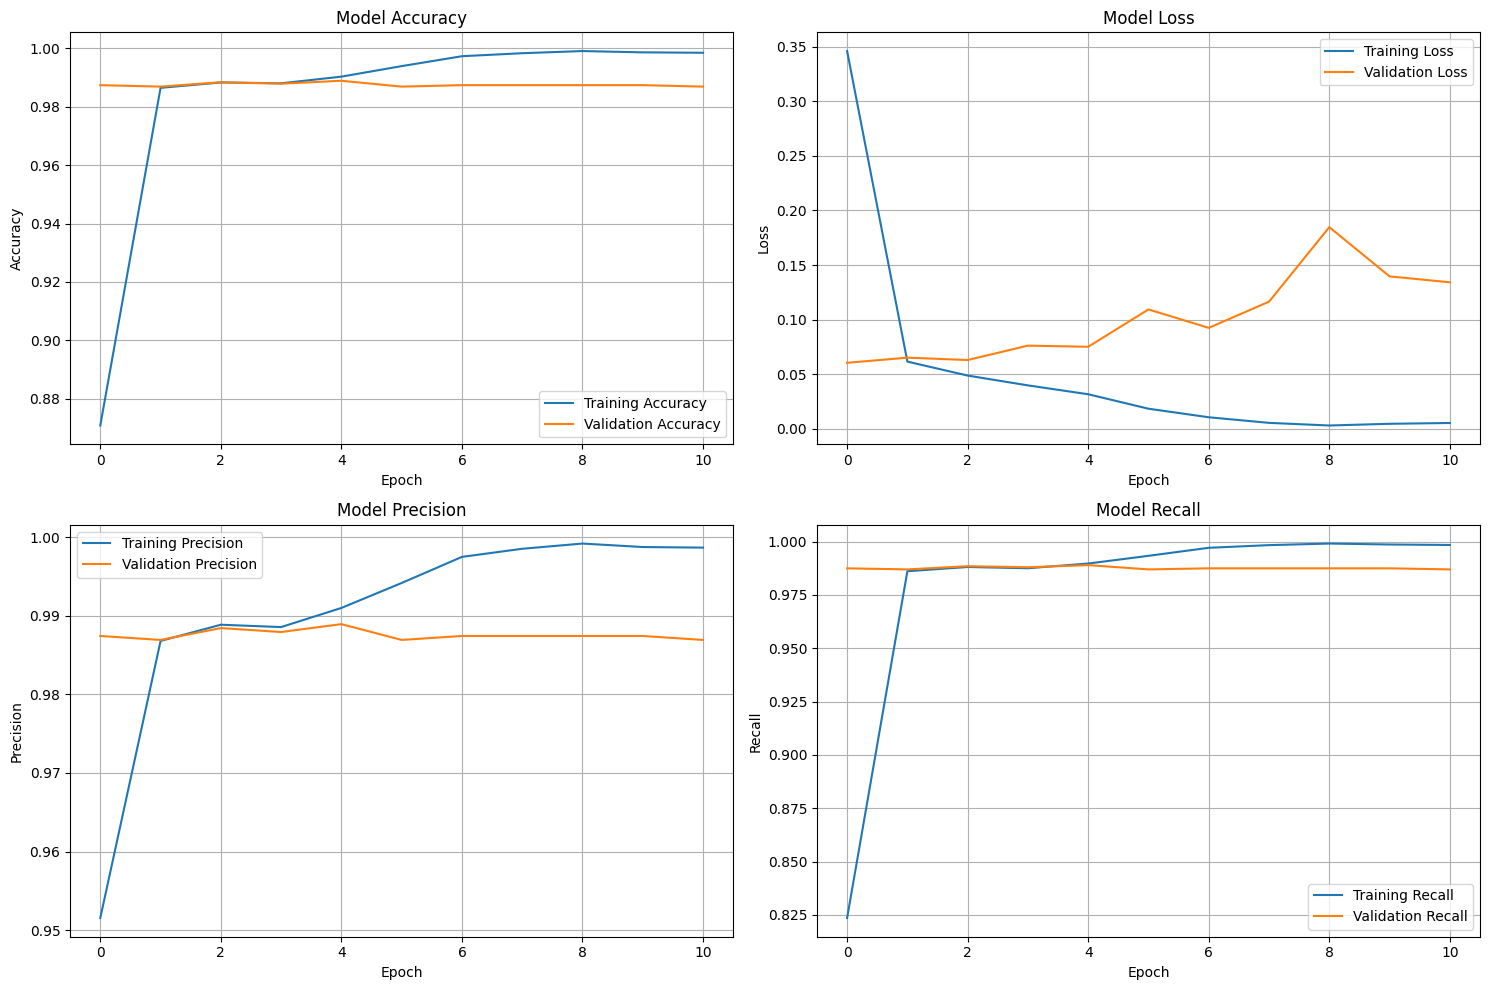

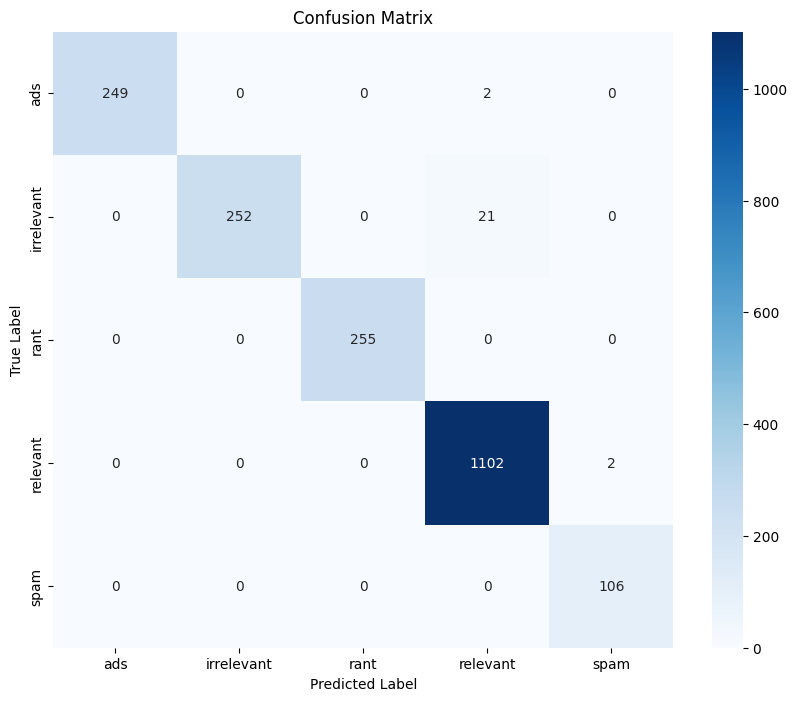

In [96]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return cm

cm = plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

# 12. FEATURE IMPORTANCE ANALYSIS

Text feature importance: 0.1810
Review embedding importance: 0.0186
Business embedding importance: -0.0005

Numerical Feature Importance:
avg_review_rating_by_user: 0.0885
repetitiveness_score: 0.0463
count_significantly_different_ratings: 0.0085
review_similarity: 0.0015
rating: 0.0010
avg_rating: 0.0005
category_similarity: 0.0005
num_of_reviews: 0.0000
sentiment_score: 0.0000
review_length_words: 0.0000
std_review_rating_by_user: 0.0000
posts_per_year: 0.0000
name_validity: -0.0005


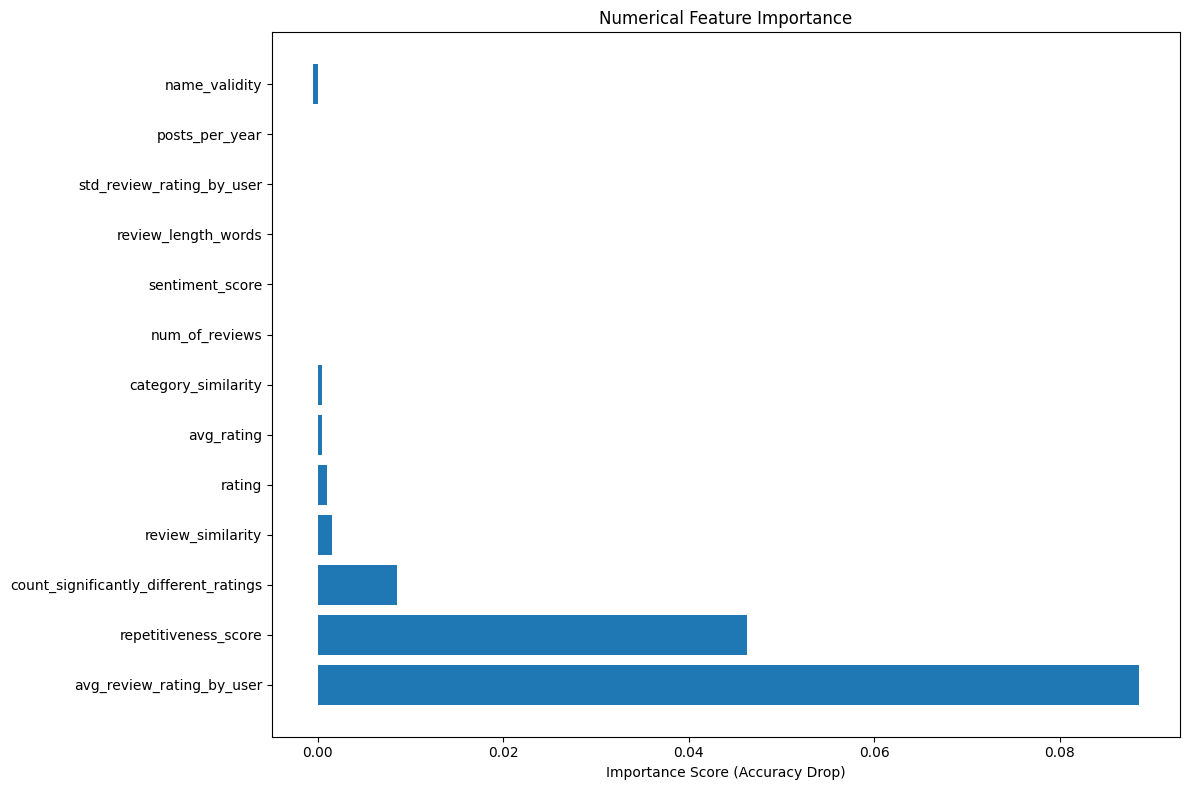

In [97]:
def analyze_feature_importance(model, X_text_val, X_features_val, feature_names):
    """
    Analyze feature importance using permutation-based approach
    """
    baseline_score = model.evaluate([X_text_val, X_features_val], y_val, verbose=0)[1]

    importance_scores = []

    # Test text importance
    X_text_shuffled = X_text_val.copy()
    np.random.shuffle(X_text_shuffled)
    text_score = model.evaluate([X_text_shuffled, X_features_val], y_val, verbose=0)[1]
    text_importance = baseline_score - text_score

    print(f"Text feature importance: {text_importance:.4f}")

    # Test embedding importance
    review_emb_dim = train_review_embeddings.shape[1]
    business_emb_dim = train_business_embeddings.shape[1]

    # Test review embedding importance
    X_features_permuted = X_features_val.copy()
    np.random.shuffle(X_features_permuted[:, :review_emb_dim])  # Shuffle review embeddings
    review_emb_score = model.evaluate([X_text_val, X_features_permuted], y_val, verbose=0)[1]
    review_emb_importance = baseline_score - review_emb_score
    print(f"Review embedding importance: {review_emb_importance:.4f}")

    # Test business embedding importance
    X_features_permuted = X_features_val.copy()
    np.random.shuffle(X_features_permuted[:, review_emb_dim:review_emb_dim+business_emb_dim])
    business_emb_score = model.evaluate([X_text_val, X_features_permuted], y_val, verbose=0)[1]
    business_emb_importance = baseline_score - business_emb_score
    print(f"Business embedding importance: {business_emb_importance:.4f}")

    # Test each numerical feature
    numerical_start_idx = review_emb_dim + business_emb_dim
    for i, feature_name in enumerate(feature_names):
        X_features_permuted = X_features_val.copy()
        np.random.shuffle(X_features_permuted[:, numerical_start_idx + i])

        permuted_score = model.evaluate([X_text_val, X_features_permuted], y_val, verbose=0)[1]
        importance = baseline_score - permuted_score
        importance_scores.append((feature_name, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    print(f"\nNumerical Feature Importance:")
    for feature, importance in importance_scores:
        print(f"{feature}: {importance:.4f}")

    # Plot feature importance
    features, scores = zip(*importance_scores)
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(features)), scores)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance Score (Accuracy Drop)')
    plt.title('Numerical Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance_scores

# Analyze feature importance
feature_importance = analyze_feature_importance(model, X_text_val, X_features_val, numerical_features)

# 13. MODEL SAVING

In [99]:
# Save the model
model.save('review_classifier_model.h5')
print("\nModel saved as 'review_classifier_model.h5'")

# Save preprocessing objects
import pickle

preprocessing_objects = {
    'tokenizer': tokenizer,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'max_len': MAX_LEN,
    'numerical_features': numerical_features,
    'review_embedding_dim': train_review_embeddings.shape[1],
    'business_embedding_dim': train_business_embeddings.shape[1]
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("Preprocessing objects saved as 'preprocessing_objects.pkl'")


Model saved as 'review_classifier_model.h5'
Preprocessing objects saved as 'preprocessing_objects.pkl'


# 14. BATCH PREDICTION FUNCTION

In [100]:
def predict_batch_reviews(df_new, model, tokenizer, scaler, label_encoder):
    """
    Predict categories for a batch of new reviews

    Args:
        df_new (DataFrame): DataFrame with 'review', embeddings, and numerical features
        model: Trained model
        tokenizer: Fitted tokenizer
        scaler: Fitted scaler
        label_encoder: Fitted label encoder

    Returns:
        DataFrame: Original data with predictions and confidence scores
    """

    # Parse embeddings for new data
    df_new_copy = df_new.copy()
    df_new_copy['review_embedding_parsed'] = df_new_copy[review_embedding_column].apply(parse_embedding)
    df_new_copy['business_desc_embedding_parsed'] = df_new_copy[business_desc_embedding_column].apply(parse_embedding)

    # Process text
    X_text_new = tokenizer.texts_to_sequences(df_new_copy[text_column])
    X_text_new = pad_sequences(X_text_new, maxlen=MAX_LEN, padding='post', truncating='post')

    # Extract embeddings
    review_emb_new = np.stack(df_new_copy['review_embedding_parsed'].values)
    business_emb_new = np.stack(df_new_copy['business_desc_embedding_parsed'].values)

    # Process numerical features
    X_num_new = df_new_copy[numerical_features].values
    X_num_new_scaled = scaler.transform(X_num_new)

    # Combine features
    X_features_new = np.concatenate([review_emb_new, business_emb_new, X_num_new_scaled], axis=1)

    # Make predictions
    predictions_proba = model.predict([X_text_new, X_features_new])
    predictions = np.argmax(predictions_proba, axis=1)
    predicted_categories = label_encoder.inverse_transform(predictions)

    # Add predictions to dataframe
    df_result = df_new.copy()
    df_result['predicted_category'] = predicted_categories
    df_result['confidence'] = np.max(predictions_proba, axis=1)

    # Add individual class probabilities
    for i, class_name in enumerate(label_encoder.classes_):
        df_result[f'prob_{class_name}'] = predictions_proba[:, i]

    return df_result

# 15. MODEL PERFORMANCE ANALYSIS

In [101]:
# Analyze predictions by category
def analyze_predictions_by_category(y_true, y_pred, y_pred_proba, label_encoder):
    """Analyze model performance by category"""

    results = []

    for i, category in enumerate(label_encoder.classes_):
        # Get indices for this category
        category_indices = np.where(y_true == i)[0]

        if len(category_indices) > 0:
            # Calculate metrics for this category
            category_accuracy = accuracy_score(
                y_true[category_indices] == i,
                y_pred[category_indices] == i
            )

            avg_confidence = np.mean(y_pred_proba[category_indices, i])

            results.append({
                'category': category,
                'count': len(category_indices),
                'accuracy': category_accuracy,
                'avg_confidence': avg_confidence
            })

    results_df = pd.DataFrame(results)
    print("\nPerformance by Category:")
    print(results_df.round(4))

    return results_df

category_performance = analyze_predictions_by_category(y_true, y_pred, y_pred_proba, label_encoder)



Performance by Category:
     category  count  accuracy  avg_confidence
0         ads    251    0.9920          0.9912
1  irrelevant    273    0.9231          0.9258
2        rant    255    1.0000          0.9998
3    relevant   1104    0.9982          0.9867
4        spam    106    1.0000          0.9999
